<a href="https://colab.research.google.com/github/wangwangwang77/pydata-book/blob/1st-edition/Optimal_Control_Ramsey%E2%80%93Cass%E2%80%93Koopmans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**From a series of application of modern interpolation methods for economics: written by [Mahdi E Kahou](https://sites.google.com/site/mahdiebrahimikahou/about-me)**


Note: This notebook should take at most **50 seconds** to run. From `Runtime` choose `Run all` to run this code.

## Setup
Most optimal control problems in economics can be written as set of first order differential equations. For instance consider the famous [Ramsey–Cass–Koopmans model](https://en.wikipedia.org/wiki/Ramsey%E2%80%93Cass%E2%80%93Koopmans_model) of consumption and capital.

Consider the following problem:

$\begin{align}
\max_{c(t)} \quad & \int_{0}^\infty e^{-\rho t} u\big(c(t)\big) dt \\
 \text{s.t} ̇\quad &\dot{k} = f(k)-\delta k -c\\
\quad &  k_0 \quad \text{given}
\end{align}$

After writing the Hamilotonian the problem will be reduced to a two-dimensional system of differential equations:

$\begin{align}
\quad & \dot{c} = \frac{c}{\sigma(c)}\big[f'(k)-(\delta+\rho)\big] \\
\quad &\dot{k} = f(k)-\delta k -c\\
\quad &  k_0 \quad \text{given}\\
\quad & TVC
\end{align}$

where $\sigma(c) \equiv -\frac{c u''(c)}{u'}$.

We can think of this probelm as a root of a functional operator as follows:

$\begin{align}
\quad & \frac{d}{dt}\begin{bmatrix}
c(t)\\
k(t)
\end{bmatrix} - G(k(t),c(t)) = 0\\
\quad &  k(0)-k_0 = 0 \quad \text{given}
\end{align}$

In this exmaple I focus on the case of $u(c) = \frac{c^{1-\sigma}}{1-\sigma}$, and $f(k) = k^\alpha$.

## Importing packages (ignore it)



In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
fontsize= 14
ticksize = 14
figsize = (10, 4.5)
params = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params)

## Setting up the model parameters

In [ ]:
class Params:
    def __init__(self,
                 alpha = 1.0/3.0,
                 rho = 0.1111,
                 delta = 0.1,
                 k_0 = 1.0,
                 sigma = 1.0, #CRRA coeff,
                ):
        self.alpha = alpha
        self.rho = rho
        self.delta = delta
        self.k_0 = k_0
        self.sigma = sigma

## Some useful functions:
$f(k)$: Production function

$f'(k)$: derivative of the production function

$SS$: Steady states of the capital and consumption

In [ ]:
def f(k):
    alpha = Params().alpha
    return k**alpha

In [ ]:
def f_prime(k):
    alpha = Params().alpha
    return  alpha*(k**(alpha -1))

In [ ]:
class SS: #steady state
    def __init__(self):
        self.delta = Params().delta
        self.rho = Params().rho
        self.alpha = Params().alpha

        self.k_ss = ((self.delta+self.rho)/self.alpha)**(1.0/(self.alpha - 1))
        self.c_ss = f(self.k_ss)-self.delta*self.k_ss

## Preparing the grid and the data loader (for stochastic gradient method)

In [ ]:
class Grid_data:
    def __init__(self,
                 max_T = 32,
                 batch_size = 8,
                 mesh_step = 0.3):


        self.max_T = max_T
        self.mesh_step = mesh_step
        self.batch_size = batch_size

        self.time_range = torch.arange(start = 0.0, end = self.max_T , step = self.mesh_step)
        dim = self.time_range.shape[0]
        self.grid = self.time_range.reshape([dim,1])

In [ ]:
class Data_label(Dataset):

    def __init__(self,data):
        self.time = data
        self.n_samples = self.time.shape[0]

    def __getitem__(self,index):
            return self.time[index]

    def __len__(self):
        return self.n_samples

In [ ]:
train_data = Grid_data().grid
train_labeled = Data_label(train_data)
train = DataLoader(dataset = train_labeled, batch_size = 8 , shuffle = True )

## Defining the differential operator (backward differencing):
$\begin{align}
\frac{d}{dt} f(t) ≈ \frac{f(t)-f(t-\epsilon)}{\epsilon}
\end{align}$

In [ ]:
def derivative_back(model,t): #backward differencing
    epsilon = 1.0e-8
    sqrt_eps = np.sqrt(epsilon)
    return (model(t)- model(t-sqrt_eps))/sqrt_eps

## Defining $G$:
$\begin{align}
G(k,c) \equiv \begin{bmatrix}
\frac{c}{\sigma(c)}\big[f'(k)-(\delta+\rho)\big]\\
f(k)-\delta k -c
\end{bmatrix}
\end{align}$

In [ ]:
def G(model,t):
    sigma = Params().sigma
    delta = Params().delta
    rho = Params().rho
    c = model(t)[:,[0]]
    k = model(t)[:,1:]
    dcdt = (c/sigma)*(f_prime(k)-(delta+rho))
    dkdt = f(k)-delta*k - c
    return  torch.stack((dcdt,dkdt),1).squeeze()

## Defining the approximating function (neural networks):
Here is the approximation function (deep neural net) is $\hat{q}=[\hat{c},\hat{k}] : \mathbb{R} → \mathbb{R}^2$.






In [ ]:
class NN(nn.Module):
    def __init__(self,
                 dim_hidden = 128,
                layers = 4,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias

        torch.manual_seed(123)
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.Tanh())

        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.Tanh())

        module.append(nn.Linear(self.dim_hidden,2))
        module.append(nn.Softplus(beta = 1.0)) #The softplus layer ensures c>0,k>0

        self.q = nn.Sequential(*module)


    def forward(self, x):
        out = self.q(x) # first element is consumption, the second element is capital
        return  out

## Optimization (Learning) process




#### An auxiliary function that extracts the learning rate






In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
q_hat= NN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(q_hat.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)

In [ ]:
num_epochs = 751

In [ ]:
for epoch in range(num_epochs):
    for i, time in enumerate(train):
        time_zero = torch.zeros([1,1])

        res_ode =  derivative_back(q_hat,time) - G(q_hat,time)
        res_init = q_hat(time_zero)[:,[1]] - Params().k_0

        loss_ode = res_ode.pow(2).mean()
        loss_init = res_init.pow(2).mean()
        loss = 0.8*loss_ode + 0.2*loss_init

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    scheduler.step()
    if epoch == 0:
         print('epoch' , ',' , 'loss' , ',', 'loss_ode' , ',' , 'loss_initial' , ',', 'lr_rate')
    if epoch % 250 == 0:
         print(epoch,',',"{:.2e}".format(loss.item()),',',
                "{:.2e}".format(loss_ode.item()) , ',' , "{:.2e}".format(loss_init.item())
               ,',', "{:.2e}".format(get_lr(optimizer)) )

epoch , loss , loss_ode , loss_initial , lr_rate
0 , 1.38e-03 , 1.63e-03 , 3.62e-04 , 1.00e-03
250 , 3.80e-06 , 3.86e-06 , 3.60e-06 , 6.40e-04
500 , 3.22e-07 , 4.01e-07 , 7.14e-09 , 3.28e-04
750 , 1.42e-06 , 1.77e-06 , 7.00e-10 , 2.10e-04


## Plotting the results



In [ ]:
time_test = Grid_data().grid
c_hat_path = q_hat(time_test)[:,[0]].detach()
k_hat_path = q_hat(time_test)[:,[1]].detach()

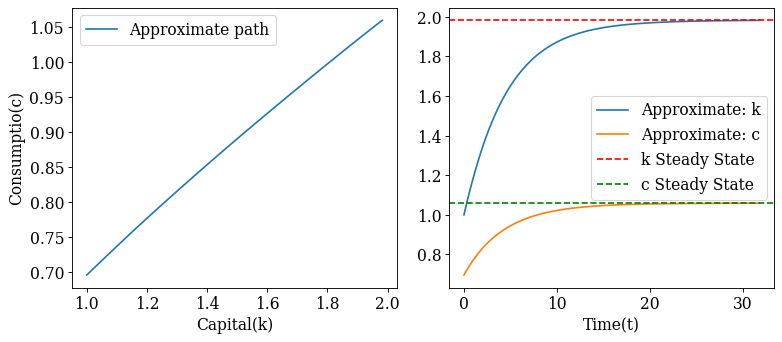

In [ ]:
plt.subplot(1, 2, 1)


plt.plot(k_hat_path,c_hat_path, label = r"Approximate path")
plt.ylabel(r"Consumptio(c)")
plt.xlabel(r"Capital(k)")
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(time_test,k_hat_path,label= r"Approximate: k")
plt.plot(time_test,c_hat_path,label= r"Approximate: c")
plt.axhline(y=SS().k_ss, color='r', linestyle='--',label="k Steady State")
plt.axhline(y=SS().c_ss, color='g', linestyle='--',label="c Steady State")

plt.xlabel(r"Time(t)")
plt.tight_layout()
plt.legend(loc='best')
plt.tight_layout()
plt.show()


## Plotting the results in the phase space


In [ ]:
def c_zero_path(k): # f(k)-delta k
    delta = Params().delta
    return f(k)-delta*k
k_mesh = torch.arange(1.0, 2.1 , 0.005)
c_zero_path_mesh = c_zero_path(k_mesh)

In [ ]:
c_grid,k_grid = np.meshgrid(np.linspace(0.6,1.1,30),np.linspace(1.0,2.1,30))

dcdt = (c_grid/Params().sigma)*(f_prime(k_grid)-(Params().delta+Params().rho))
dkdt = f(k_grid)-Params().delta*k_grid-c_grid

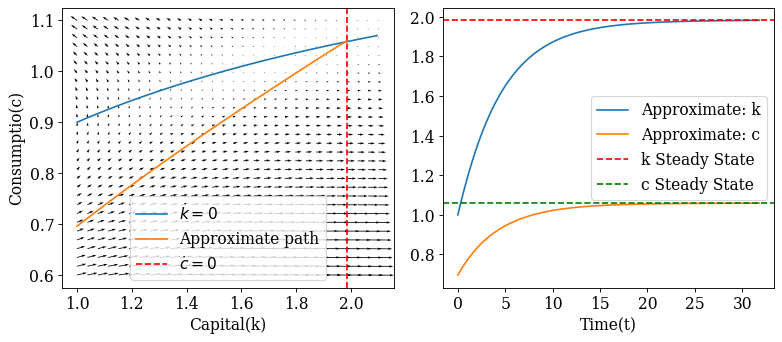

In [ ]:
plt.subplot(1, 2, 1)


plt.plot(k_mesh,c_zero_path_mesh,label= r"$\dot{k} = 0$")
plt.plot(k_hat_path,c_hat_path, label = r"Approximate path")
plt.axvline(x=SS().k_ss, color='r', linestyle='--',label=r"$\dot{c} = 0$")
plt.ylabel(r"Consumptio(c)")
plt.xlabel(r"Capital(k)")
plt.quiver(k_grid,c_grid,dkdt,dcdt)
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(time_test,k_hat_path,label= r"Approximate: k")
plt.plot(time_test,c_hat_path,label= r"Approximate: c")
plt.axhline(y=SS().k_ss, color='r', linestyle='--',label="k Steady State")
plt.axhline(y=SS().c_ss, color='g', linestyle='--',label="c Steady State")

plt.xlabel(r"Time(t)")
plt.tight_layout()
plt.legend(loc='best')
plt.tight_layout()
plt.show()



## Error analysis: Comparison with the shooting method

In [ ]:
from scipy.integrate import odeint

In [ ]:
def dg_dt(ck, t):
    sigma = Params().sigma
    delta = Params().delta
    rho = Params().rho
    return [(ck[0]/sigma)*( f_prime(ck[1])- (delta+rho) ), f(ck[1])-delta*ck[1] - ck[0]]

ts = np.linspace(0, 32, 107)
ck0 = [0.6954047,Params().k_0] #Be careful the c(0) = 0.6954047 is only for these parameters, you have to change it if you change the parameters of the problem
sol = odeint(dg_dt, ck0, ts)
c_path_shoot = sol[:,0]
k_path_shoot = sol[:,1]

In [ ]:
c_rel_error = (c_path_shoot - c_hat_path.squeeze().numpy())/c_path_shoot
k_rel_error = (k_path_shoot - k_hat_path.squeeze().numpy())/k_path_shoot

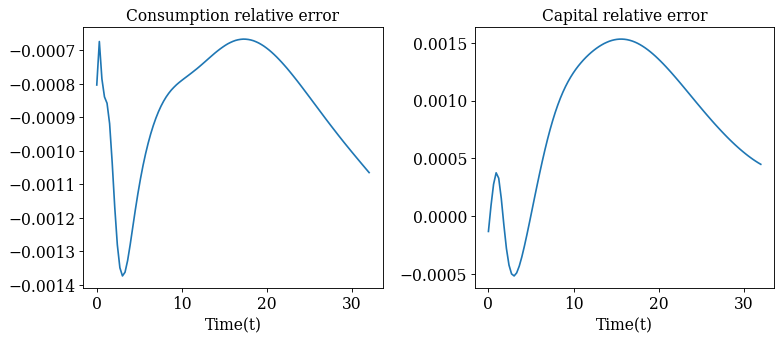

In [ ]:
plt.subplot(1, 2, 1)


plt.plot(ts,c_rel_error)
plt.xlabel(r"Time(t)")
plt.title(r"Consumption relative error")

plt.subplot(1, 2, 2)

plt.plot(ts,k_rel_error)
plt.xlabel(r"Time(t)")
plt.title(r"Capital relative error")
plt.tight_layout()
plt.show()


## Dynamic of the optimization process
The prpcces of finding a solution is an iterative process. The following video shows the convergence of this iterative procedure.

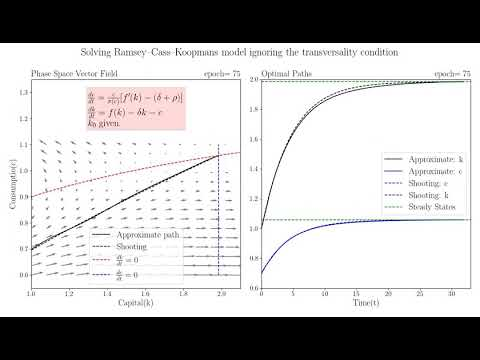

In [ ]:
from IPython.display import YouTubeVideo
id = 'B-zf73bID1o'
YouTubeVideo(id = id, width = 800, height= 600)